## **Loading necessary libraries**

In [43]:
#Import all the libraries needed
import pandas as pd    # to load dataset
import numpy as np     # for mathematic equation
from nltk.corpus import stopwords   # to get collection of stopwords
from sklearn.model_selection import train_test_split       # for splitting dataset
from tensorflow.keras.preprocessing.text import Tokenizer  # to encode text to int
from tensorflow.keras.preprocessing.sequence import pad_sequences   # to do padding or truncating
from tensorflow.keras.models import Sequential     # the model
from tensorflow.keras.layers import Embedding, LSTM, Dense # layers of the architecture
from tensorflow.keras.callbacks import ModelCheckpoint   # save model
from tensorflow.keras.models import load_model   # load saved model
import re

## **Loading train and test datasets**

In [44]:
import pathlib
from google.colab import drive
drive.mount('/content/drive')
data_dir1 = pathlib.Path('/content/sample_data/phm_train.csv')
data_dir2 = pathlib.Path('/content/sample_data/phm_test.csv')

tweetDataTrain = pd.read_csv(data_dir1)
tweetDataTest = pd.read_csv(data_dir2)

print(tweetDataTrain)
print(tweetDataTest)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
          tweet_id  label                                              tweet
0     6.430000e+17      0  user_mention all i can tell you is i have had ...
1     6.440000e+17      0  my doctor told me stop he gave me sum pop i mi...
2     8.150000e+17      1  i take tylenol and i wake up in the middle of ...
3     6.820000e+17      0  i got xans in an advil bottle i dont take them...
4     6.440000e+17      1  mom says i need to stop eating so much bc ive ...
...            ...    ...                                                ...
9986  6.480000e+17      1                          that vicodin messed me up
9987  5.710000e+17      0                  user_mention get some tylenol lol
9988  6.470000e+17      0                          like a walking tamiflu ad
9989  6.990000e+17      0                         klay and steph on steroids
9990  8.230000e+17      

# **Load stopwords package**

In [45]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
english_stops = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [46]:
def load_dataset():
    x_train = tweetDataTrain['tweet']
    y_train = tweetDataTrain['label']

    x_test = tweetDataTest['tweet']
    y_test = tweetDataTest['label']

    # PRE-PROCESS REVIEW
    x_train = x_train.replace({'<.*?>': ''}, regex = True)          # remove html tag
    x_train = x_train.replace({'[^A-Za-z]': ' '}, regex = True)     # remove non alphabet
    x_train = x_train.apply(lambda tweet: [w for w in tweet.split() if w not in english_stops])  # remove stop words and tokenize
    x_train = x_train.apply(lambda tweet: [w.lower() for w in tweet])   # lower case

    x_test = x_test.replace({'<.*?>': ''}, regex = True)          # remove html tag
    x_test = x_test.replace({'[^A-Za-z]': ' '}, regex = True)     # remove non alphabet
    x_test = x_test.apply(lambda tweet: [w for w in tweet.split() if w not in english_stops])  # remove stop words and tokenize
    x_test = x_test.apply(lambda tweet: [w.lower() for w in tweet])   # lower case


    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = load_dataset()

print('Tweets')
print(x_train, '\n')
print('Labels')
print(y_train)
print('Tweets')
print(x_test, '\n')
print('Labels')
print(y_test)

Tweets
0       [user, mention, tell, relapses, cure, hear, do...
1       [doctor, told, stop, gave, sum, pop, mix, w, a...
2       [take, tylenol, wake, middle, night, put, ice,...
3       [got, xans, advil, bottle, dont, take, shits, ...
4       [mom, says, need, stop, eating, much, bc, ive,...
                              ...                        
9986                                    [vicodin, messed]
9987                   [user, mention, get, tylenol, lol]
9988                         [like, walking, tamiflu, ad]
9989                              [klay, steph, steroids]
9990                [horrible, pops, another, xanax, url]
Name: tweet, Length: 9991, dtype: object 

Labels
0       0
1       0
2       1
3       0
4       1
       ..
9986    1
9987    0
9988    0
9989    0
9990    0
Name: label, Length: 9991, dtype: int64
Tweets
0       [try, run, away, iv, needle, doctor, drug, w, ...
1       [knew, took, ambien, sleep, early, im, ready, ...
2       [mean, get, celexa, reas

# **Get mean length of tweets as maximum length**

In [47]:
def get_max_length():
    tweet_length = []
    for tweet in x_train:
        tweet_length.append(len(tweet))

    return int(np.ceil(np.mean(tweet_length)))

# **Tokenization, Padding and Encoding**

In [48]:
x_train = x_train.tolist()
x_test = x_test.tolist()

token = Tokenizer(lower=False)    # no need lower, because already lowered the data in load_data()
token.fit_on_texts(x_train)
x_train = token.texts_to_sequences(x_train)
x_test = token.texts_to_sequences(x_test)

max_length = get_max_length()

x_train = pad_sequences(x_train, maxlen=max_length, padding='post', truncating='post')
x_test = pad_sequences(x_test, maxlen=max_length, padding='post', truncating='post')

total_words = len(token.word_index) + 1   # add 1 because of 0 padding

print('Encoded X Train\n', x_train, '\n')
print('Encoded X Test\n', x_test, '\n')
print('Maximum review length: ', max_length)

Encoded X Train
 [[    2     1   200 ...   944  3624  1952]
 [  115   122   147 ...   193    40   322]
 [    6     3   330 ...   626  1710    29]
 ...
 [    7   529  1739 ...     0     0     0]
 [12658 12659     8 ...     0     0     0]
 [  645  1436   174 ...     0     0     0]] 

Encoded X Test
 [[  98  606  109 ...  193    4  318]
 [ 585   11   56 ...   16  707   55]
 [ 327   12 1209 ...  778    5   88]
 ...
 [   2    1  126 ...    0    0    0]
 [   2    1    3 ...    0    0    0]
 [  59    8    9 ...    0    0    0]] 

Maximum review length:  10


# **LSTM architecture**

In [49]:
# ARCHITECTURE
EMBED_DIM = 32
LSTM_OUT = 64

model = Sequential()
model.add(Embedding(total_words, EMBED_DIM, input_shape=(max_length,)))
model.add(LSTM(LSTM_OUT))
model.add(Dense(1, activation='sigmoid'))


print(model.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 10, 32)         │       405,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 430,017 (1.64 MB)

 Trainable params: 430,017 (1.64 MB)

 Non-trainable params: 0 (0.00 B)

None


# **Hyperparameter tuning and model training**

In [57]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Use early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=3)

# Checkpoint to save best model
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)

# Model
model = Sequential()
model.add(Embedding(input_dim= total_words, output_dim=128))  # Tune this value
model.add(LSTM(128, dropout=0.3, recurrent_dropout=0.3))   # Tune units and dropout
model.add(Dense(1, activation='sigmoid'))

# Compile with learning rate tuning
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Fit model with tuned batch size and epochs
history = model.fit(x_train, y_train,
          batch_size= 64,  # try 32, 64, 128
          epochs=5, # try 5, 10, 20
          validation_split=0.2,
          callbacks=[early_stop, checkpoint])


Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.6760 - loss: 0.6710

125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 0.6761 - loss: 0.6708 - val_accuracy: 0.7374 - val_loss: 0.5525
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7030 - loss: 0.5687

125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.7031 - loss: 0.5686 - val_accuracy: 0.7579 - val_loss: 0.4671
Epoch 3/5
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7850 - loss: 0.4737

125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.7851 - loss: 0.4735 - val_accuracy: 0.8324 - val_loss: 0.3961
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8236 - loss: 0.4053

125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - accuracy: 0.8236 - loss: 0.4053 - val_accuracy: 0.8329 - val_loss: 0.3739
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8447 - loss: 0.3506

125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.8447 - loss: 0.3506 - val_accuracy: 0.8334 - val_loss: 0.3715


# **Model accuracy validation**

In [58]:
pred = model.predict(x=x_test)
y_pred = (pred >= 0.5) * 1

#y_pred = model.predict(x_test)

true = 0
for i, y in enumerate(y_test):
    if y == y_pred[i]:
        true += 1


print('Correct Prediction: {}'.format(true))
print('Wrong Prediction: {}'.format(len(y_pred) - true))
print('Accuracy: {}'.format(true/len(y_pred)*100))

105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
Correct Prediction: 2674
Wrong Prediction: 657
Accuracy: 80.27619333533474


# **AUC and ROC curves**

In [59]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


In [60]:
y_probs = model.predict(x_test)  # This gives probabilities (floats between 0 and 1)


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [61]:
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)


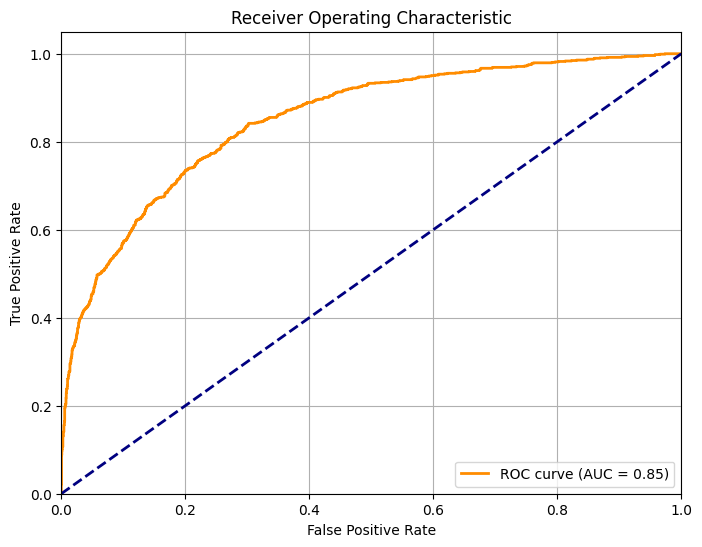

In [62]:
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()


**Since the AUC value of the LSTM model is 0.85, the model has a good accuracy **

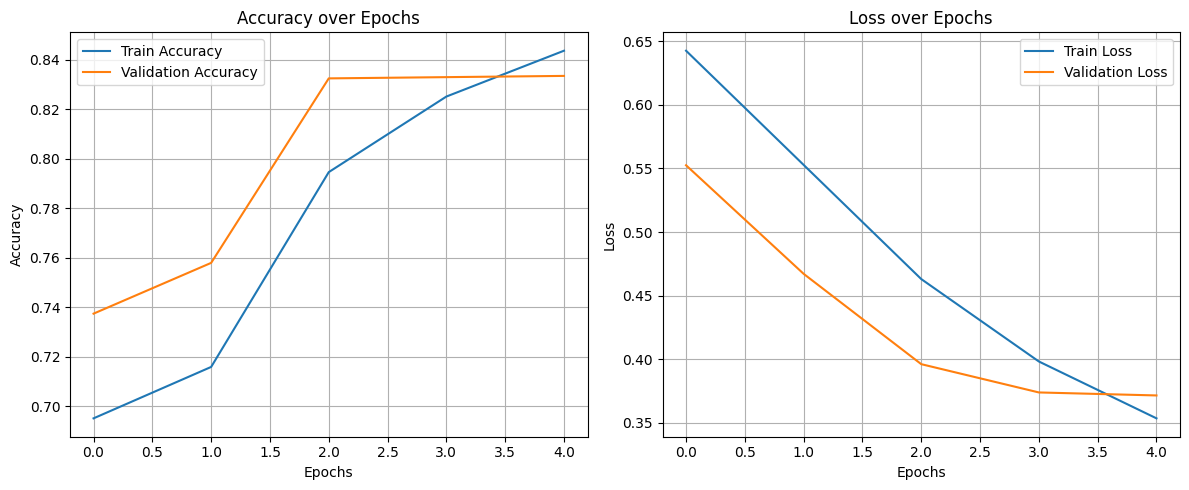

In [63]:
import matplotlib.pyplot as plt

fig,axs = plt.subplots(1,2, figsize=(12,5))

#accuracy plot
axs[0].plot(history.history['accuracy'],label = 'Train Accuracy')
axs[0].plot(history.history['val_accuracy'],label = 'Validation Accuracy')
axs[0].set_title('Accuracy over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].grid(True)

#Loss plot
axs[1].plot(history.history['loss'],label = 'Train Loss')
axs[1].plot(history.history['val_loss'],label = 'Validation Loss')
axs[1].set_title('Loss over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

# **BiLSTM**

In [65]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Early stopping & checkpoint
early_stop = EarlyStopping(monitor='val_loss', patience=3)
checkpoint = ModelCheckpoint('best_bilstm_model.h5', monitor='val_accuracy', save_best_only=True)

# Bi-LSTM Model
model = Sequential()
model.add(Embedding(input_dim=total_words, output_dim=128))  # Same embedding layer
model.add(Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3)))  # Bi-LSTM
model.add(Dense(1, activation='sigmoid'))  # Output layer

# Compile
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(
    x_train, y_train,
    batch_size=32,
    epochs=5,
    validation_split=0.2,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.6733 - loss: 0.6487

250/250 ━━━━━━━━━━━━━━━━━━━━ 35s 97ms/step - accuracy: 0.6734 - loss: 0.6485 - val_accuracy: 0.7374 - val_loss: 0.5081
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.7563 - loss: 0.4992

250/250 ━━━━━━━━━━━━━━━━━━━━ 36s 79ms/step - accuracy: 0.7565 - loss: 0.4991 - val_accuracy: 0.8324 - val_loss: 0.3827
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.8358 - loss: 0.3749

250/250 ━━━━━━━━━━━━━━━━━━━━ 23s 91ms/step - accuracy: 0.8358 - loss: 0.3748 - val_accuracy: 0.8329 - val_loss: 0.3718
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 92ms/step - accuracy: 0.8768 - loss: 0.2993 - val_accuracy: 0.8319 - val_loss: 0.3823
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.8954 - loss: 0.2610

250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - accuracy: 0.8953 - loss: 0.2610 - val_accuracy: 0.8369 - val_loss: 0.3723


In [66]:
pred = model.predict(x=x_test)
y_pred = (pred >= 0.5) * 1

#y_pred = model.predict(x_test)

true = 0
for i, y in enumerate(y_test):
    if y == y_pred[i]:
        true += 1


print('Correct Prediction: {}'.format(true))
print('Wrong Prediction: {}'.format(len(y_pred) - true))
print('Accuracy: {}'.format(true/len(y_pred)*100))

105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step
Correct Prediction: 2709
Wrong Prediction: 622
Accuracy: 81.32692885019513


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


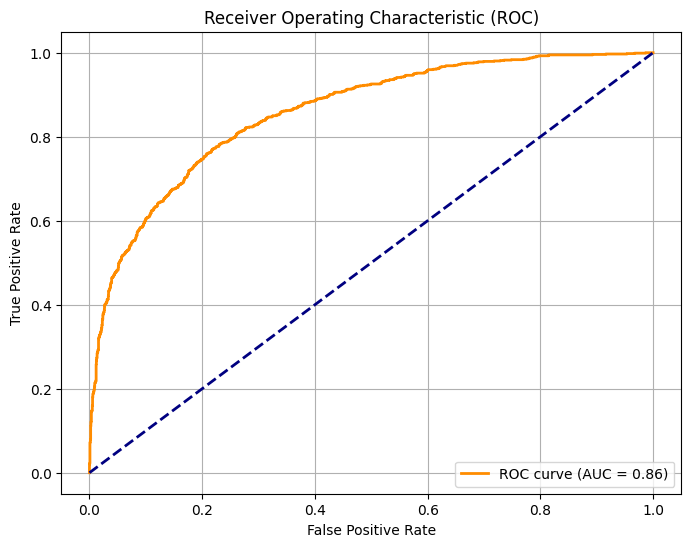

In [67]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict probabilities
y_probs = model.predict(x_test)

# ROC and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid()
plt.show()


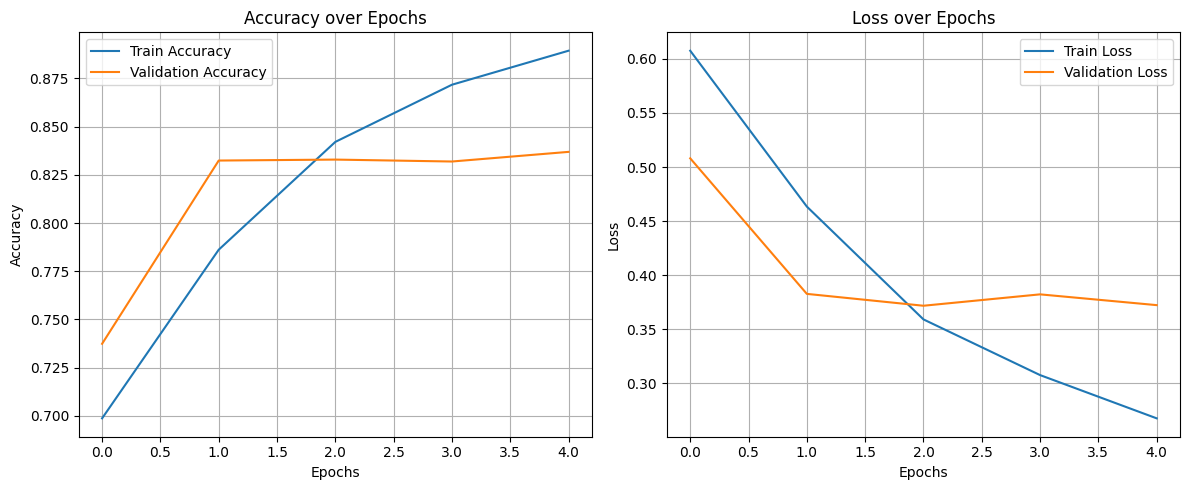

In [68]:
import matplotlib.pyplot as plt

fig,axs = plt.subplots(1,2, figsize=(12,5))

#accuracy plot
axs[0].plot(history.history['accuracy'],label = 'Train Accuracy')
axs[0].plot(history.history['val_accuracy'],label = 'Validation Accuracy')
axs[0].set_title('Accuracy over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].grid(True)

#Loss plot
axs[1].plot(history.history['loss'],label = 'Train Loss')
axs[1].plot(history.history['val_loss'],label = 'Validation Loss')
axs[1].set_title('Loss over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()